# Mini Project 2: Hypothesis Testing of Standard Assumptions in Theoretical Financial Mathematics

In mathematical finance, it is commonly assumed that log returns of stocks follow a normal distribution. This project tests that assumption using historical market data.

We explore the following:

1. Whether specific time periods show evidence of normally distributed log returns.
2. Whether excluding volatile data improves normality.
3. Constructing a portfolio with normally distributed returns.
4. Testing normality of two previously constructed portfolio - one high risk and one low risk portfolio
5. Screening a large set of stocks for normal log returns.


In [1]:
# Package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
sns.set_style('darkgrid')

import yfinance as yf
import datetime as dt


## 1. Testing the Normality of Log Returns for the S&P 500 ETF (VOO)

We begin by analyzing the log returns of the Vanguard S&P 500 ETF (VOO) over the past two years. We use a probability plot and apply the D’Agostino–Pearson test to evaluate whether the distribution is normal.


In [2]:
# Get 2 years of VOO data and compute log returns
start_date = dt.datetime.today() - dt.timedelta(days = 2*365)
end_date = dt.datetime.today()

V_index = yf.download('VOO', start=start_date, end=end_date)
V_returns = V_index['Close'] / V_index['Close'].shift(1)
V_logreturns = np.log(V_returns.dropna())['VOO'].values


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


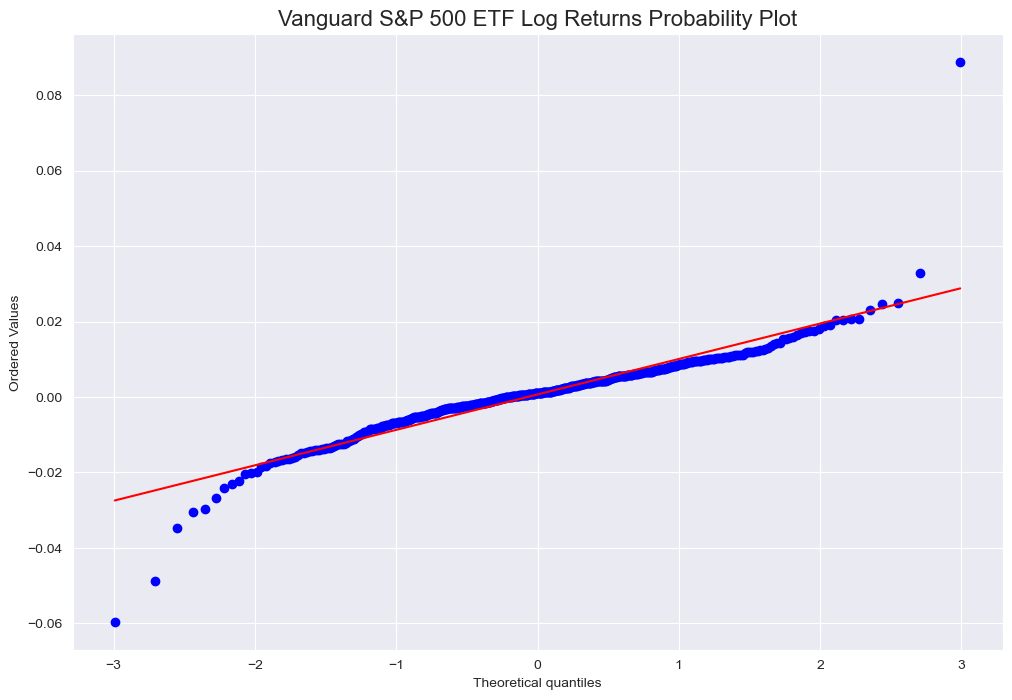

In [3]:
# Probability plot to visually assess normality
axes = plt.subplots(1, 1, figsize=(12, 8))
stats.probplot(V_logreturns, dist="norm", plot=axes[1])
axes[1].set_title("Vanguard S&P 500 ETF Log Returns Probability Plot", fontsize=16)
axes[1].grid(True)
plt.show()


In [4]:
# Perform normality test on full 2-year return series
p_V = stats.normaltest(V_logreturns)[1]
print(f"Vanguard S&P 500 ETF log return distribution: p-value = {p_V:.4f}")
if p_V < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")


Vanguard S&P 500 ETF log return distribution: p-value = 0.0000
→ Statistically significant evidence that the data is NOT normally distributed.


### Takeaway for Section 1

The log returns of the S&P 500 ETF (VOO) over the full 2-year period show deviations from normality. However, visual and statistical tests indicate that the assumption of normality may hold during specific stable subperiods, suggesting time dependence in the return distribution characteristics.


## 2. Investigating the Effect of Time Periods on Normality

To assess how market conditions affect normality, we divide the return data into halves. By testing only the first half (which may exclude recent volatility), we explore whether the distribution appears closer to normal when periods of market stress are removed.


In [5]:
# Slice first half of the return series
half_index = int(np.floor(len(V_logreturns)/2))
V_logreturns_historical = V_logreturns[0:half_index]
V_historical = V_index['Close'].iloc[:half_index]


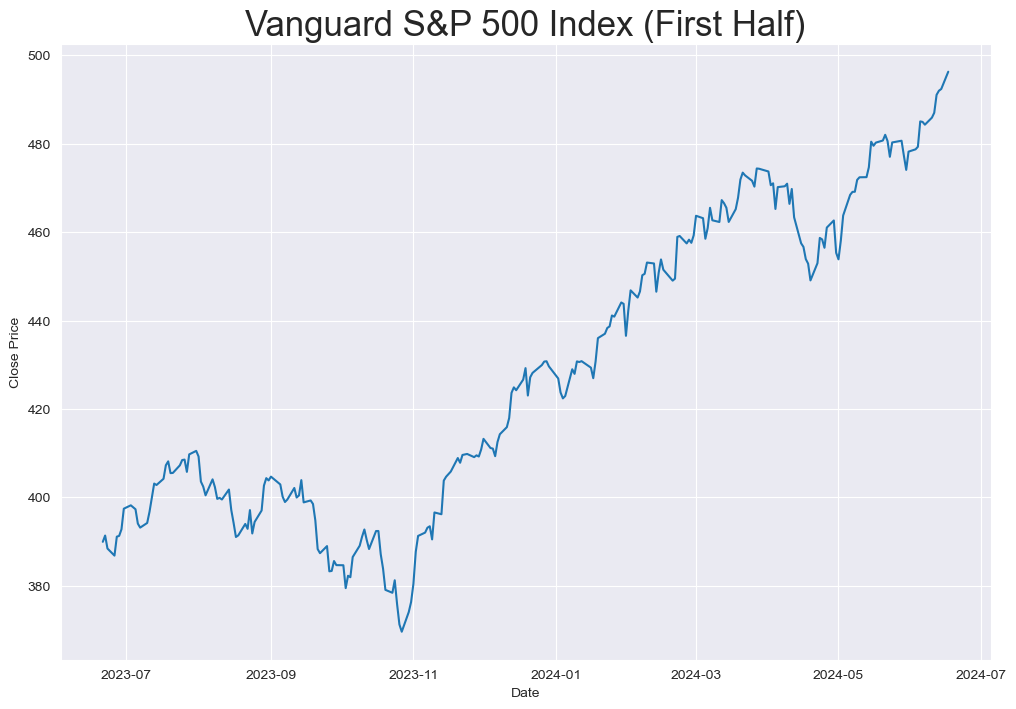

In [6]:
# Plot price series for first half
plt.figure(figsize=(12, 8))
plt.plot(V_historical)
plt.title('Vanguard S&P 500 Index (First Half)', fontsize=25)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


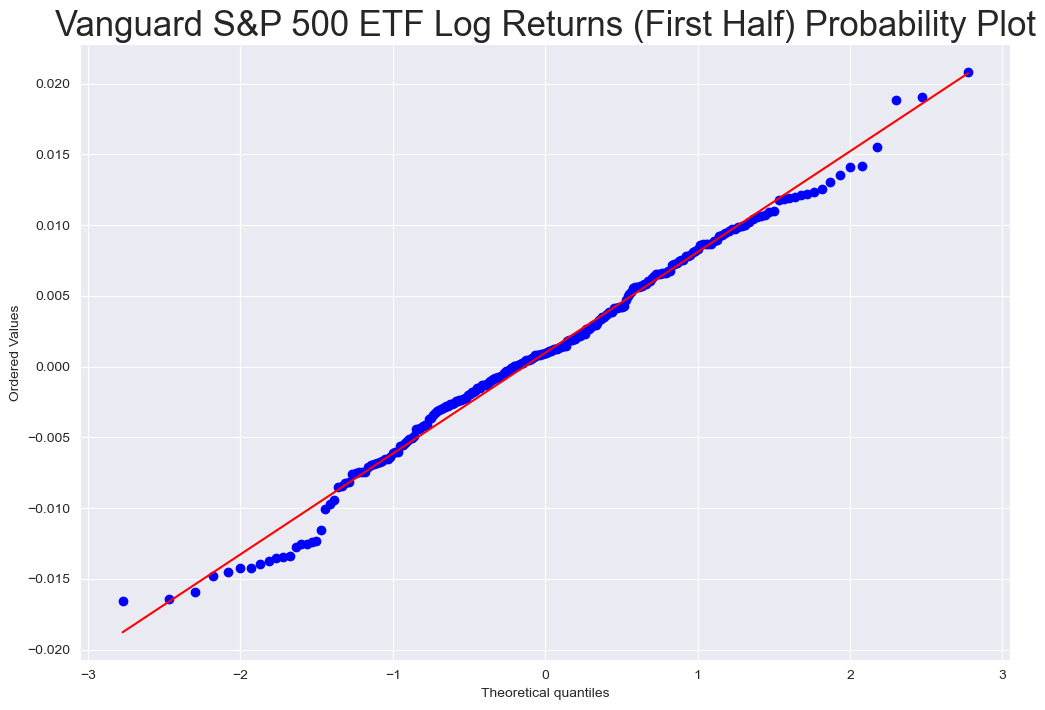

In [7]:
# Probability plot for the first half
plt.figure(figsize=(12,8))
stats.probplot(V_logreturns_historical, plot=plt)
plt.title('Vanguard S&P 500 ETF Log Returns (First Half) Probability Plot', size=25)
plt.show()


In [8]:
# Perform normality test on the first half of returns
p_V_historical = stats.normaltest(V_logreturns_historical)[1]
print(f"S&P log return (First Half) distribution: p-value = {p_V_historical:.4f}")
if p_V_historical < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")


S&P log return (First Half) distribution: p-value = 0.5508
→ No statistically significant evidence against normality.


### Takeaway for Section 2

By isolating the earlier, less volatile half of the data, the log returns appear more consistent with a normal distribution. This supports the idea that periods of high volatility can significantly affect the validity of the normality assumption. When tested over the entire two years, du to recent volatility in the market, there was significant evidence against normality. Clearly find that for instance the Vanguard S&P 500 ETF displays normality for it's log returns over the time period of 2023 - 2024. 2025 was a volatile time , so we see devaition from normality.


## 3. Constructing a Portfolio with Normally Distributed Log Returns

Here, we build a portfolio using broad market ETFs. These ETFs are inherently diversified and systematically rebalanced, which tends to smooth out extreme returns and may result in distributions that more closely resemble the normal distribution.

We test each ETF for normality using both statistical tests and visual tools.


In [10]:
tickers = ["SCHB", "SCHX", "ITOT", "VTI", "SPY"]
start_date = dt.datetime.today()-dt.timedelta(days=2*365)
end_date = dt.datetime.today()-dt.timedelta(days=365)

stock = yf.download(tickers, start=start_date, end=end_date)
prices = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
log_returns = np.log(prices / prices.shift(1)).dropna()


[*********************100%***********************]  5 of 5 completed


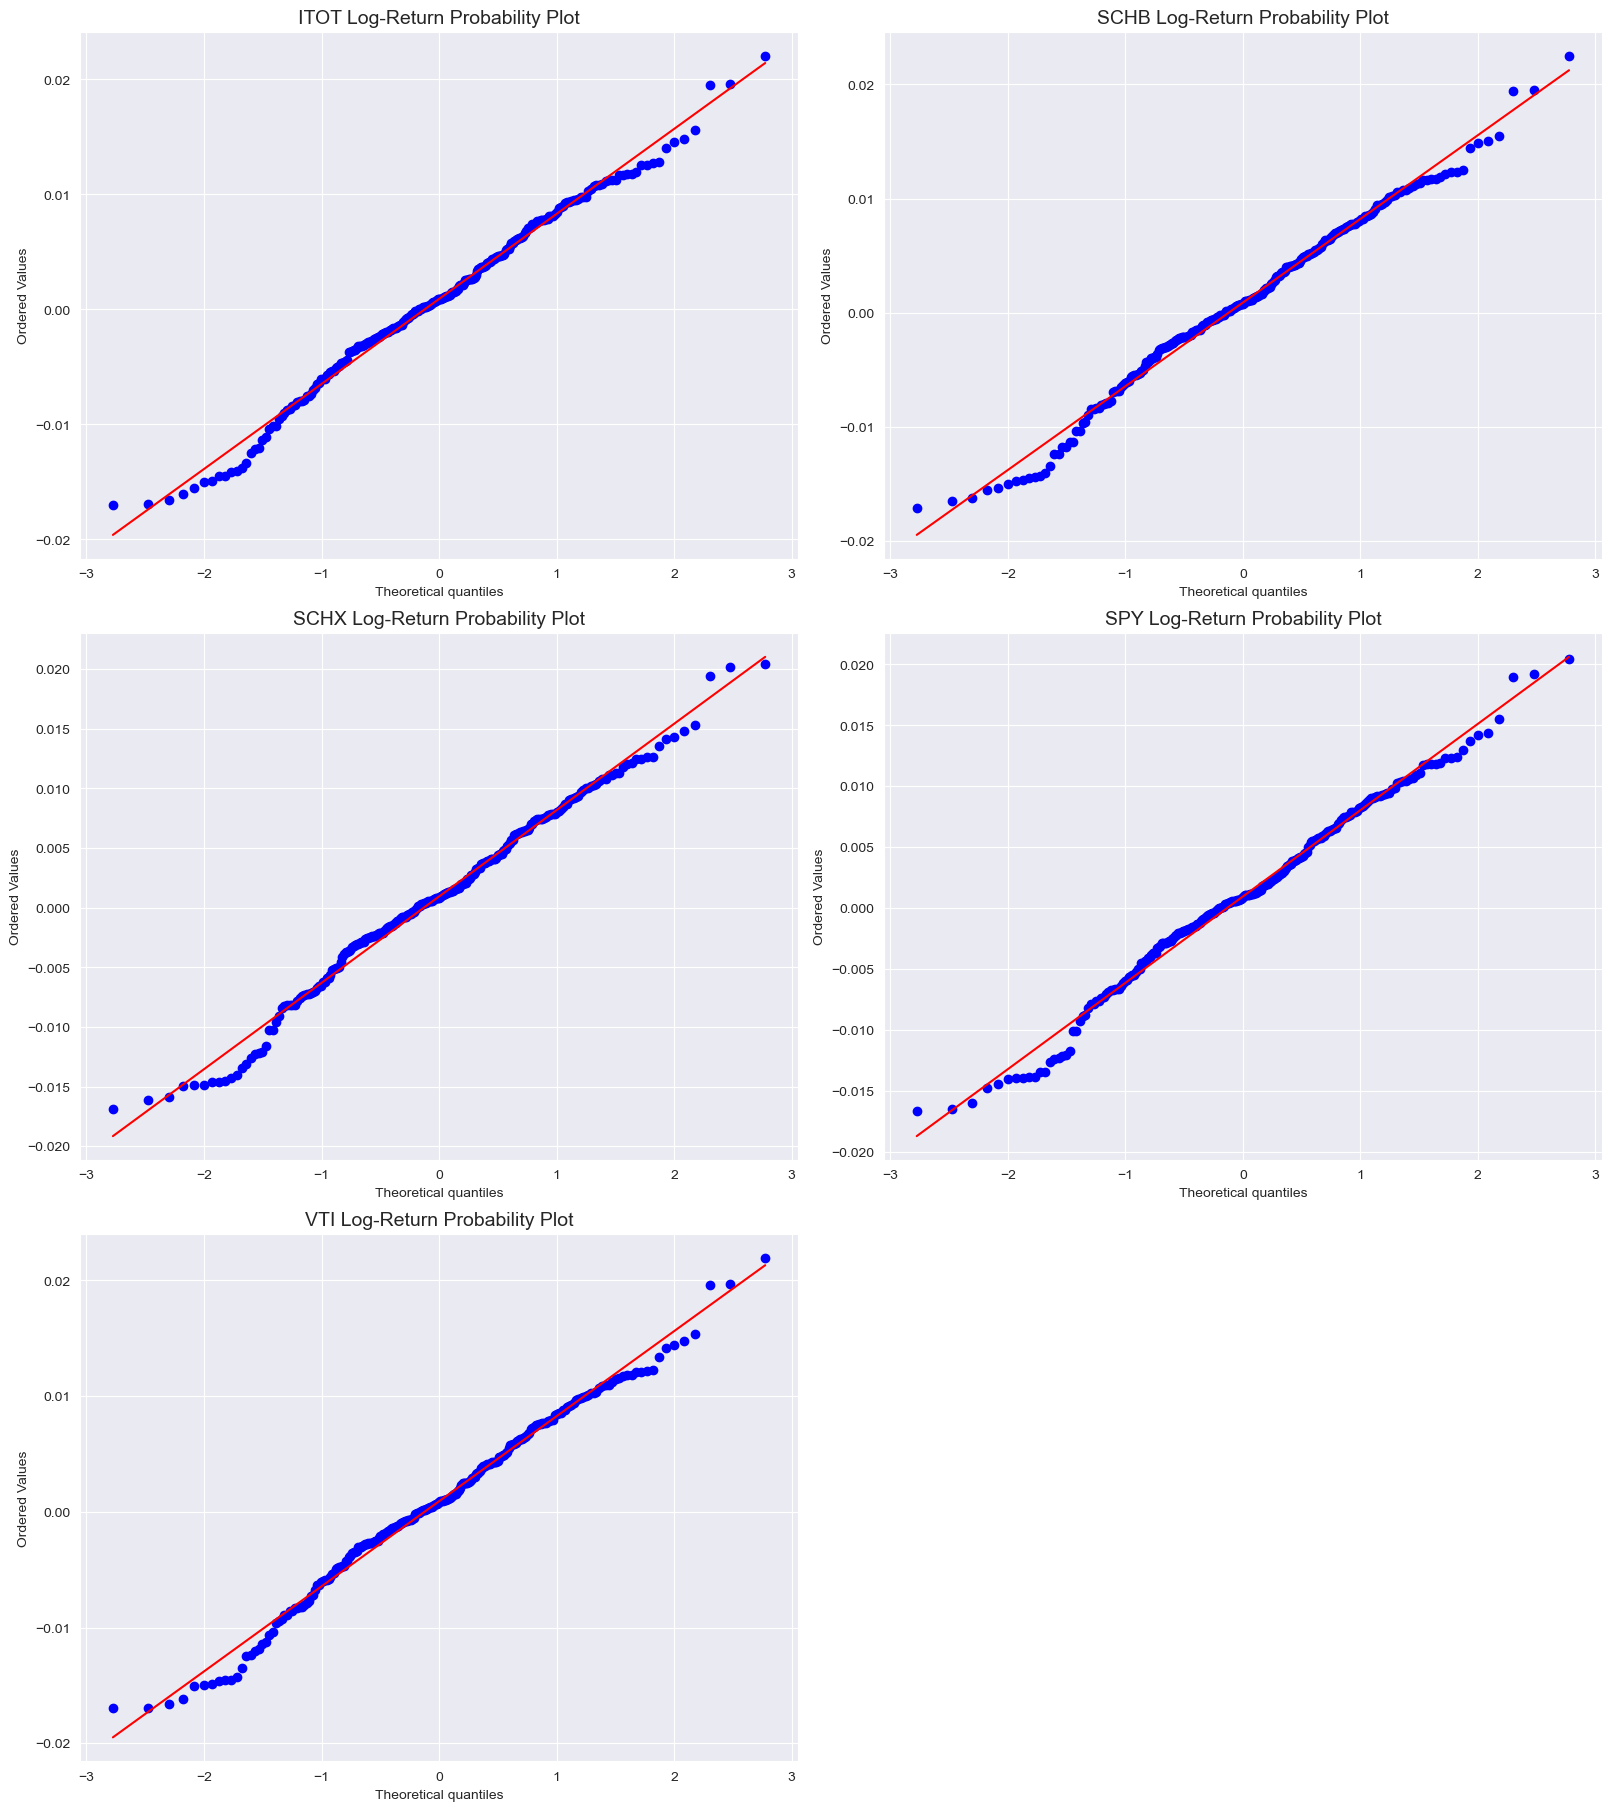

In [11]:
# QQ plots for visual comparison of normality
import math
tickers = log_returns.columns
n = len(tickers)
n_cols = 2
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 6), constrained_layout=True)
axes = axes.flatten()

for ax, tkr in zip(axes, tickers):
    stats.probplot(log_returns[tkr].dropna(), dist="norm", plot=ax)
    ax.set_title(f"{tkr} Log-Return Probability Plot", fontsize=14)
    ax.grid(True)

for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.show()


In [12]:
# Perform normality test on each ETF
p_vals = log_returns.apply(lambda col: stats.normaltest(col)[1])
normality = pd.DataFrame({"p_value": p_vals}).assign(is_normal=lambda df: df["p_value"] >= 0.05).sort_values("p_value")

print("Normality test (D’Agostino–Pearson) — H₀: data come from a normal distribution\n")
for tkr, row in normality.iterrows():
    verdict = "✅  no evidence against normality" if row.is_normal else "❌  reject normality at 5%"
    print(f"{tkr:<4}  p = {row.p_value:7.4f}   {verdict}")


Normality test (D’Agostino–Pearson) — H₀: data come from a normal distribution

SCHB  p =  0.5666   ✅  no evidence against normality
VTI   p =  0.5728   ✅  no evidence against normality
SPY   p =  0.5735   ✅  no evidence against normality
SCHX  p =  0.5835   ✅  no evidence against normality
ITOT  p =  0.6209   ✅  no evidence against normality


### Takeaway for Section 3

The constructed portfolio of broad market ETFs generally passes normality tests. This supports the hypothesis that diversified and systematically rebalanced instruments have return distributions that are closer to normal, likely due to averaging effects across many underlying assets. Why do these stocks pass normality tests more easily ? 

- **Built-in diversification : Hundreeds and thousands of constitutents makes extreme moves in any one name average out, pushing skew and kurtosis towards the Gaussian ideal**
- **Regular, rules based reconsitutions suppresses single stock idiosyncracies**


## 4. Testing a Previously Constructed Portfolio

We now test the log return distribution of two portfolios from Mini Project 1 over two different periods:

- June 5, 2023 – December 5, 2023  
- June 5, 2023 – June 5, 2024

By comparing short-term and longer-term distributions, we assess whether normality holds consistently or varies with market conditions.


### 4a. Low Risk Portfolio: Normality Assessment

This portfolio consists of conservative holdings across equities, bonds, and commodities:

- VOO (equities)
- BND, SHY (bonds)
- XLP (consumer staples)
- GLD (gold)

We test whether the log returns of the weighted portfolio are normally distributed in each of the two time windows.


#### Period 1: June 5, 2023 – December 5, 2023

We analyze whether the low risk portfolio exhibits normally distributed returns during a relatively calm half year period.


In [25]:
low_tickers = ["VOO", "BND", "SHY", "XLP", "GLD"]
low_weights = np.array([0.39999, 0.0500138, 0.40, 0.05, 0.09999], dtype=float)
low_weights /= low_weights.sum()

low_end_date = dt.datetime(2023,12,5)
low_start_date = dt.datetime(2023,6,5)

low_prices = yf.download(low_tickers, start=low_start_date, end=low_end_date + dt.timedelta(days=1), progress=False)['Close']
low_log_rets = np.log(low_prices / low_prices.shift(1)).dropna()
low_port_log_rets = low_log_rets.dot(low_weights)


In [26]:
# Perform normality test
low_p = stats.normaltest(low_port_log_rets)[1]
print(f"Low-risk portfolio log return distribution: p-value = {low_p:.4f}")
if low_p < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")


Low-risk portfolio log return distribution: p-value = 0.2163
→ No statistically significant evidence against normality.


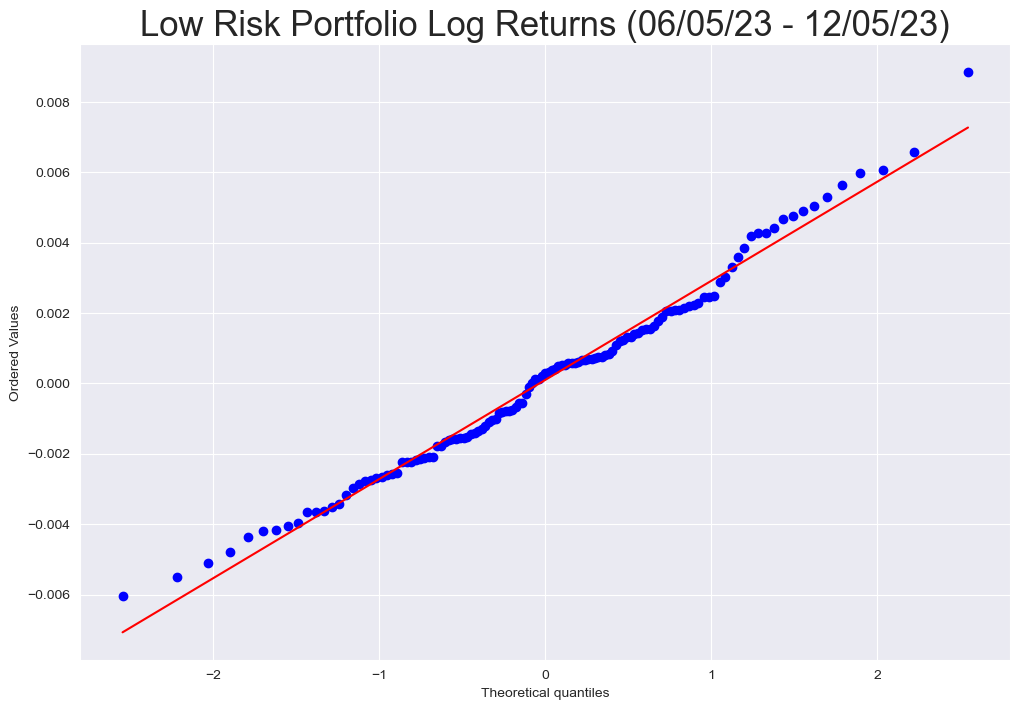

In [27]:
# QQ plots
plt.figure(figsize=(12,8))
stats.probplot(low_port_log_rets, plot=plt)
plt.title('Low Risk Portfolio Log Returns (06/05/23 - 12/05/23)', size=25)
plt.show()

#### Period 2: June 5, 2023 – June 5, 2024

Next, we test a full year of log returns. This includes more market events and volatility, which may affect normality.


In [29]:
low_tickers = ["VOO", "BND", "SHY", "XLP", "GLD"]
low_weights = np.array([0.39999, 0.0500138, 0.40, 0.05, 0.09999], dtype=float)
low_weights /= low_weights.sum()

low_end_date = dt.datetime(2024,6,5)
low_start_date = dt.datetime(2023,6,5)

low_prices = yf.download(low_tickers, start=low_start_date, end=low_end_date + dt.timedelta(days=1), progress=False)['Close']
low_log_rets = np.log(low_prices / low_prices.shift(1)).dropna()
low_port_log_rets = low_log_rets.dot(low_weights)

In [30]:
# Perform normality test
low_p = stats.normaltest(low_port_log_rets)[1]
print(f"Low-risk portfolio log return distribution: p-value = {low_p:.4f}")
if low_p < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

Low-risk portfolio log return distribution: p-value = 0.0403
→ Statistically significant evidence that the data is NOT normally distributed.


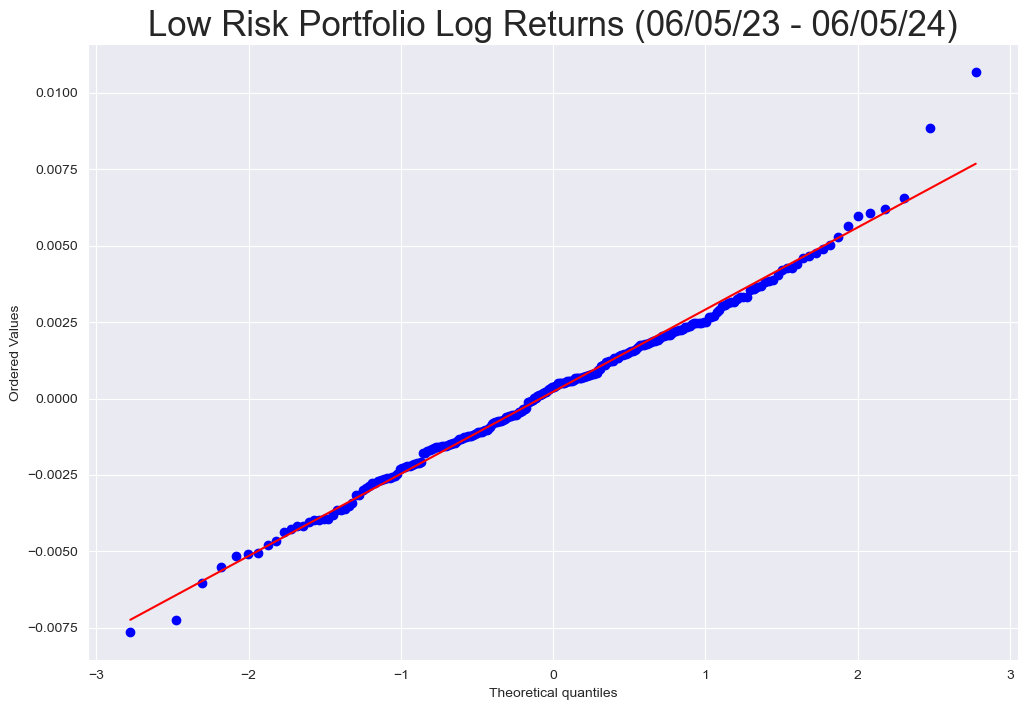

In [31]:
plt.figure(figsize=(12,8))
stats.probplot(low_port_log_rets, plot=plt)
plt.title('Low Risk Portfolio Log Returns (06/05/23 - 06/05/24)', size=25)
plt.show()

### 4b. High Risk Portfolio: Normality Assessment

This portfolio consists of high-growth, high volatility assets:

- TSLA
- NVDA 
- QQQ
- AMD
- META

We apply the same tests to this portfolio to observe how exposure to volatile assets influences the normality of returns over different time frames.


#### Period 1: June 5, 2023 – December 5, 2023

We analyze whether the high risk portfolio exhibits normally distributed returns during a half year period.


In [32]:
high_tickers = ["TSLA", "NVDA", "QQQ", "AMD", "META"]
high_weights = np.array([0.101601, 0.240756, 0.457581, 0.100063, 0.1], dtype=float)
high_weights /= high_weights.sum()

high_end_date = dt.datetime(2023,12,5)
high_start_date = dt.datetime(2023,6,5)

high_prices = yf.download(high_tickers, start=high_start_date, end=high_end_date + dt.timedelta(days=1), progress=False)['Close']
high_log_rets = np.log(high_prices / high_prices.shift(1)).dropna()
high_port_log_rets = high_log_rets.dot(high_weights)


In [33]:
# Perform normality test
high_p = stats.normaltest(high_port_log_rets)[1]
print(f"High-risk portfolio log return distribution: p-value = {high_p:.4f}")
if high_p < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")


High-risk portfolio log return distribution: p-value = 0.8380
→ No statistically significant evidence against normality.


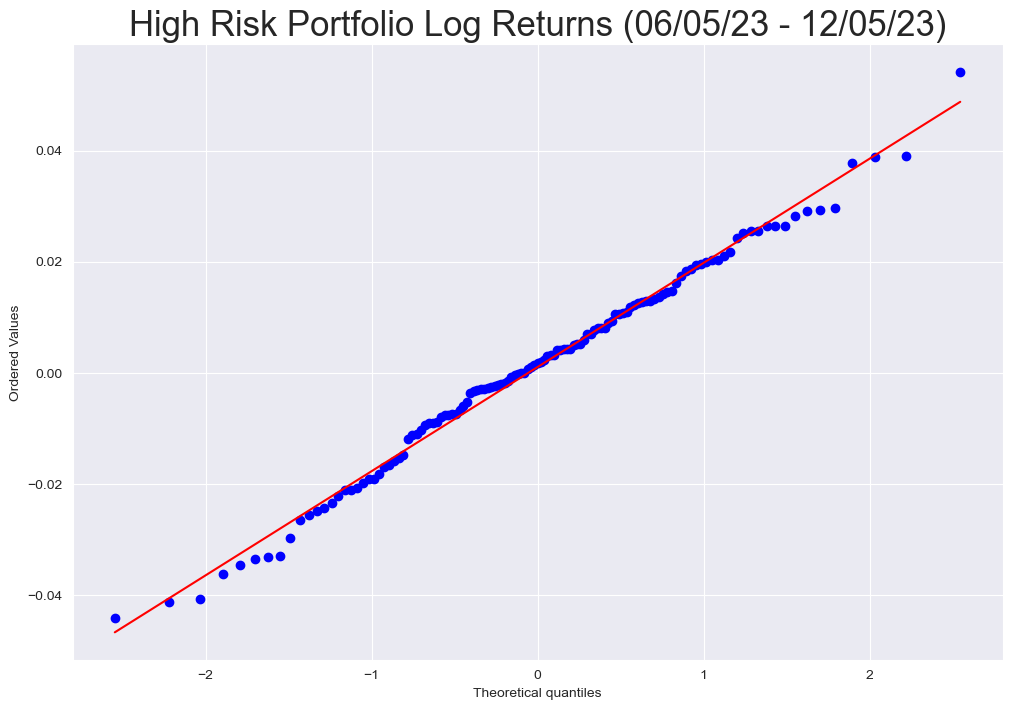

In [35]:
# QQ plots
plt.figure(figsize=(12,8))
stats.probplot(high_port_log_rets, plot=plt)
plt.title('High Risk Portfolio Log Returns (06/05/23 - 12/05/23)', size=25)
plt.show()

#### Period 2: June 5, 2023 – June 5, 2024

Next, we test a full year of log returns. This includes more market events and volatility, which may affect normality.

In [36]:
high_tickers = ["TSLA", "NVDA", "QQQ", "AMD", "META"]
high_weights = np.array([0.101601, 0.240756, 0.457581, 0.100063, 0.1], dtype=float)
high_weights /= high_weights.sum()

high_end_date = dt.datetime(2024,6,5)
high_start_date = dt.datetime(2023,6,5)

high_prices = yf.download(high_tickers, start=high_start_date, end=high_end_date + dt.timedelta(days=1), progress=False)['Close']
high_log_rets = np.log(high_prices / high_prices.shift(1)).dropna()
high_port_log_rets = high_log_rets.dot(high_weights)

In [37]:
# Perform normality test
high_p = stats.normaltest(high_port_log_rets)[1]
print(f"High-risk portfolio log return distribution: p-value = {high_p:.4f}")
if high_p < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

High-risk portfolio log return distribution: p-value = 0.0001
→ Statistically significant evidence that the data is NOT normally distributed.


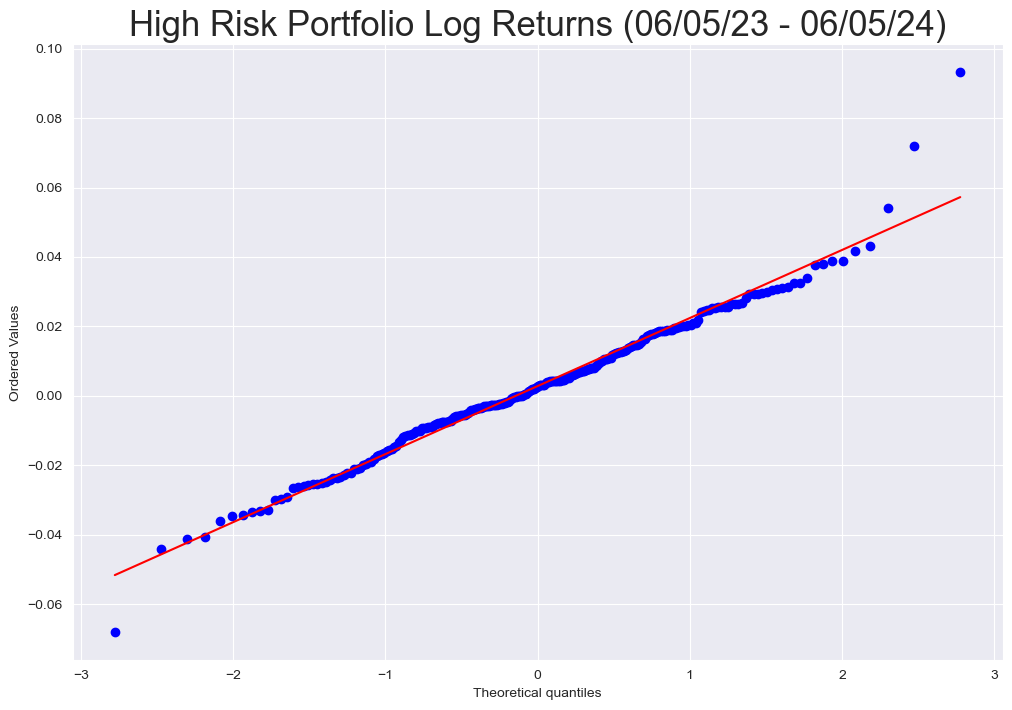

In [39]:
# QQ plots
plt.figure(figsize=(12,8))
stats.probplot(high_port_log_rets, plot=plt)
plt.title('High Risk Portfolio Log Returns (06/05/23 - 06/05/24)', size=25)
plt.show()

### Takeaway for Section 4

The portfolio level analysis shows that both low risk and high risk portfolios may exhibit normality in calm market conditions (e.g., June 2023 - December 2023). However, this behavior often breaks down over longer periods or during volatility. For instance (June 2023 - June 2024).


## 5. Screening the S&P 500 for Normally Distributed Stocks

We download the list of S&P 500 constituents and retrieve their daily prices from 2020 to the present. For each stock, we compute log returns and apply the D’Agostino–Pearson test.

Stocks for which we fail to reject the null hypothesis (p-value ≥ 0.05) are considered to have log returns that do not significantly deviate from normality. 

The result is a short list of companies whose return distribution looks closest to Gaussian in this sample window, making them suitable for models that assume normality.

In [40]:
import re
table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
universe = table["Symbol"].astype(str).apply(lambda s: re.sub(r"\.", "-", s)).tolist()
print(f"{len(universe)} tickers pulled.")


503 tickers pulled.


In [42]:
prices = yf.download(universe, start="2020-01-01", progress=False)['Close']
logret = np.log(prices / prices.shift(1)).dropna()
pvals = logret.apply(lambda x: stats.normaltest(x)[1])

normal_names = pvals[pvals >= 0.05].index.tolist()
print("Stocks that fail to reject normality:", normal_names)

passed = pvals[pvals >= 0.05].sort_values(ascending=False)
passed


Stocks that fail to reject normality: ['ED', 'EXC', 'LEN', 'WEC']


Ticker
ED     0.207387
LEN    0.191028
WEC    0.072016
EXC    0.063523
dtype: float64

### Takeaway for Section 5

A small subset of S&P 500 stocks fails to reject the null hypothesis of normality in their daily log returns. These tend to be stable, high cap stocks. Screening for normality can help identify candidates that align with Gaussian based financial modeling assumptions.


### Final Takeaway

This project tested the standard assumption in financial mathematics that log returns of assets are normally distributed. Through empirical analysis of individual ETFs, diversified portfolios, and a large universe of stocks, the results showed that:

- **Normality may hold in calm, stable periods** but often breaks down during volatile markets.
- **Diversification improves normality**, as seen in broad market ETFs and balanced portfolios.
- **High volatility portfolios and longer time windows** tend to exhibit significant deviations from the Gaussian model.
- **Systematic screening** reveals that only a minority of stocks consistently exhibit normal return distributions.

These findings emphasize the importance of **context, time horizon, and portfolio construction** when applying theoretical models that assume normality. While the normal distribution remains a useful approximation, its validity must be critically assessed in empirical applications.
